In [1]:
import numpy as np

import seaborn

import time
import matplotlib.pyplot as plt


###  Set up initial parameters for environment 


In [6]:
#  Set up initial parameters for environment 
MAP = ['SFFF', 
       'FHFH', 
       'FFFH', 
       'HFFG']

desc = np.array([[state_desc for state_desc in row] for row in MAP])
nrow, ncol = desc.shape
actions = [ "left", "down", "right","up"]
nA = len(actions) # actions number
nS = nrow * ncol # states number
rs = {
      "H": 0,
      "F": 0,
      "S": 0,
      "G": 1
    }

is_slippery = False
gamma = 0.75

R_positive = 1
r = 0


### Implement helpful functions

In [33]:
def to_s(row, col):
    return row*4 + col


def get_next_state(r, c, action):
    """actions: [0, 1, 2, 3] = [left, down, right, up]"""
    if action == 3:
        r = max(0, r - 1)
    elif action == 1:
        r = min(nrow - 1, r + 1)
    elif action == 0:
        c = max(0, c - 1)
    elif action == 2:
        c = min(ncol - 1, c + 1)
    return r, c


def get_reward(letter, new_letter):
    return rs[new_letter]


In [31]:
def get_dynamics(ncol, nrow, nS, nA):
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    for r in range(nrow):
        for c in range(ncol):
            s = to_s(r, c)
            for a in range(nA):
                dynamics = P[s][a]
                letter = desc[r, c]
                if letter in 'HG': # terminal states
                    # (p, s', reward, is_terminal)
                    dynamics.append((0, s, 0, True))
                else:
                    if is_slippery:
                        # define the perpendicular trajectory actions, with the action
                        for b in [(a - 1) % 4, a, (a + 1) % 4]:
                            new_r, new_c = get_next_state(r, c, b)
                            new_s = to_s(new_r, new_c)
                            new_letter = desc[new_r, new_c]
                            terminated = new_letter in'HG'
                            reward = get_reward(letter, new_letter)
                            dynamics.append((1.0/3.0, new_s, reward, terminated)) # there are 2 perpendicular move trajectories, so with the action they add up to 3 probable actions
                    else:
                        new_r, new_c = get_next_state(r, c, a)
                        new_s = to_s(new_r, new_c) 
                        new_letter = desc[new_r, new_c]
                        terminated = new_letter in'HG'
                        reward = get_reward(letter, new_letter)
                        dynamics.append((1.0/3.0, new_s, reward, terminated))
    return P


### 2.a Policy iteration for policy `pi_i(s)`

In [9]:
def policy_iteration(policy, P, gamma=0.75, theta=1e-5):
    delta = np.float32("inf")
    nS = len(P.keys())
    V = np.zeros(nS)

    while theta < delta:
        delta = 0
        
        for s in range(nS):
            Vs = 0
            for action, action_p in enumerate(policy[s]):
                for (p, new_s, reward, terminated) in P[s][action]:
                    Vs += action_p * p * (reward + gamma * V[new_s])
            delta = max(delta, np.abs(V[s] - Vs))
            V[s] = Vs
    return V

(np.float64(0.0), np.float64(4.0), np.float64(4.0), np.float64(0.0))

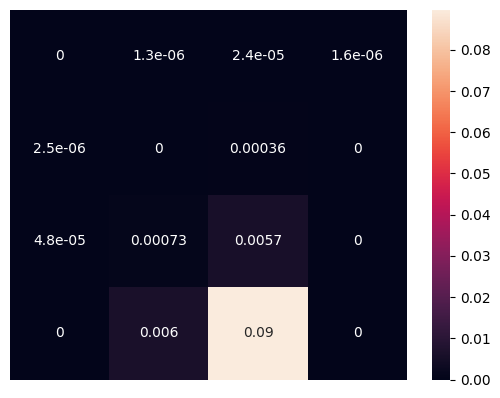

In [56]:
P = get_dynamics(ncol=ncol, nrow=nrow, nS=nS, nA=nA)
policy = np.ones([nS, nA]) / nA
V_pi = policy_iteration(policy, P, gamma=0.75, theta=1e-5)

# visualize
seaborn.heatmap(V_pi.reshape(nrow, ncol), annot=True)
plt.axis("off")

In [ ]:
## Ways for improvement policies:

# State -> improved policy
# Stetes set: (0, ... 15)
# Policy map: 
#              "left": 0, 
#              "down": 1, 
#              "right": 2, 
#              "up": 3

# 0: right
# 1: left
# 3: left
# 4: down
# 5: right
# 6: 

### 2.b Bellman's System of linear equations 

In [57]:
def bellman_SLE(policy, P, gamma=0.75):
    nS = len(P.keys())
    A = np.eye(nS)
    b = np.zeros(nS)
    
    for s in range(nS):
        for action, action_p in enumerate(policy[s]):
            for (p, new_s, reward, terminated) in P[s][action]:
                A[s][new_s] -= action_p * p * gamma
                b[s] += action_p * p * reward

    V = np.linalg.solve(A, b)
    return V, A, b

(np.float64(0.0), np.float64(4.0), np.float64(4.0), np.float64(0.0))

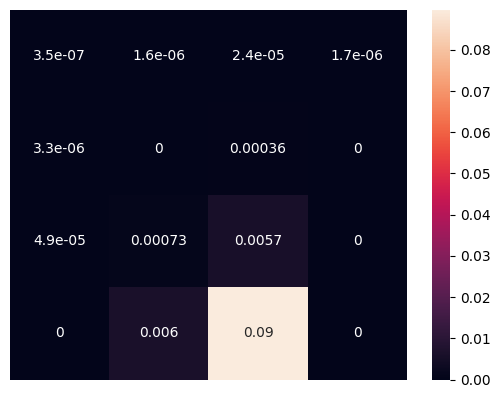

In [58]:
V_bellman, A, b = bellman_SLE(np.ones([nS, nA]) / nA, P)
seaborn.heatmap(V_bellman.reshape(nrow, ncol), annot=True)
plt.axis("off")

### 3 Evaluate Q(s, a) based on V(s) 

In [10]:
def q_from_v(P, V, s, gamma=0.75):
    nA = 4
    q = np.zeros(nA)
    for a in range(nA):
        for (p, new_s, reward, terminated) in P[s][a]:
            q[a] += p * (reward + gamma * V[new_s])
    return q


In [12]:
def Q_from_v(P, V, gamma=0.75):
    nS = V.shape[0] 
    Q = np.array([q_from_v(P, V, s, gamma=gamma) for s in range(nS)])
    return Q


3.a Q(S, a) based on V(S), found with Iterative Policy method

In [64]:
Q_pi = Q_from_v(P, V_pi, gamma=0.75)
np.round(Q_pi, 4)

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.400e-03, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 2.000e-04, 0.000e+00],
       [0.000e+00, 1.500e-03, 1.400e-03, 0.000e+00],
       [2.000e-04, 2.240e-02, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.500e-03, 2.240e-02, 2.000e-04],
       [1.500e-03, 2.240e-02, 3.333e-01, 1.400e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

3.b Q(S, a) based on V(S), found with Bellman's SLE

In [67]:
Q_bellman = Q_from_v(P, V_bellman, gamma=0.75)
np.round(Q_bellman, 4)

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.400e-03, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 2.000e-04, 0.000e+00],
       [0.000e+00, 1.500e-03, 1.400e-03, 0.000e+00],
       [2.000e-04, 2.240e-02, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.500e-03, 2.240e-02, 2.000e-04],
       [1.500e-03, 2.240e-02, 3.333e-01, 1.400e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

### 4. Equiprobable function to get random action

In [71]:
def equiprobable():
    return np.random.randint(0, nA)

### Set up FrozenLake environment 

In [73]:
import gymnasium as gym
from time import time

In [116]:
env = gym.make("FrozenLake-v1", 
               is_slippery=is_slippery, 
               desc=MAP,
                render_mode="human"
                )

env.reset()
env.render()

### 5. Implement Get_episode()

In [76]:
def get_episode(env):
    curr_state, _ = env.reset()

    terminated, truncated = False, False
    episode = []
    while not (terminated or truncated):
        action = equiprobable()
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((curr_state, action, reward, next_state, terminated, truncated))
        curr_state = next_state
    
    return episode


In [77]:
episode = get_episode(env)
episode

[(0, 1, 0.0, 4, False, False), (4, 2, 0.0, 5, True, False)]

### 6. Plot graphs of time and rewards for episode

In [79]:
import time


In [80]:
exec_time_arr = []
rewards = []
for _ in range(100):
    s_time = time.perf_counter()
    episode = get_episode(env)
    total_time = time.perf_counter() - s_time
    
    rewards.append(sum([step[2] for step in episode]))
    exec_time_arr.append(total_time)


[]

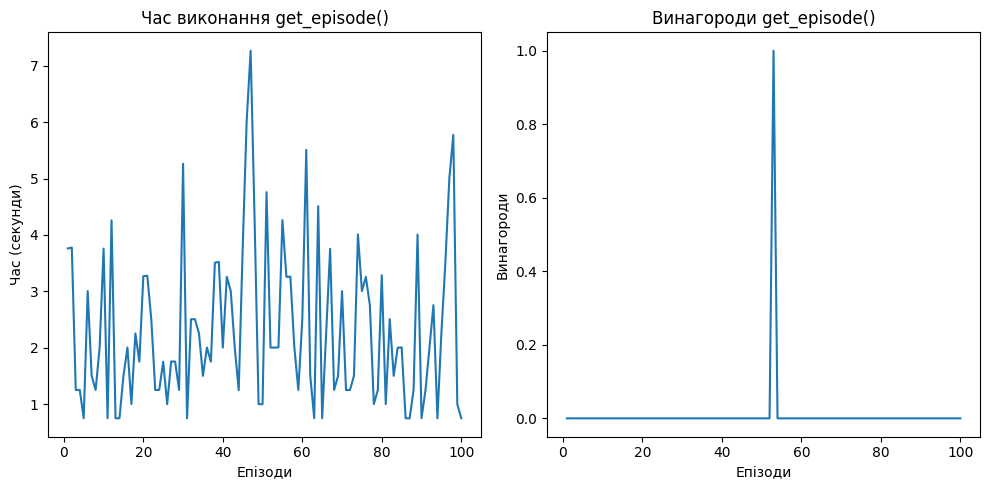

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, 101), exec_time_arr)
ax1.set_title("Час виконання get_episode()") # враховуючи час очікування потоку
ax1.set_xlabel("Епізоди")
ax1.set_ylabel("Час (секунди)")

ax2.plot(range(1, 101), rewards)
ax2.set_title("Винагороди get_episode()")
ax2.set_xlabel("Епізоди")
ax2.set_ylabel("Винагороди")

plt.tight_layout()
plt.plot()


### 7. Prepare functions for optimizing strategy with Iterative Policy, using Q(S, a) 

With value iteration, by given initial strategy

In [88]:
def improve_policy(P, V, policy, gamma=0.75):
    nS = V.shape[0]
    nA = 4
    # policy = np.ones([nS, nA]) / nA

    for s in range(nS):
        q = q_from_v(P, V, s, gamma=gamma)
        best_action = np.argwhere(q == np.max(q)).flatten()
        policy[s] = np.sum([np.eye(nA)[i] for i in best_action], axis=0) / len(best_action)
    return policy


In [69]:
def optimize_policy(P, policy, gamma=0.75, theta=1e-4):
    V_curr = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)
    policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=gamma)
    V_next = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)

    i = 1
    while np.max(np.abs(V_next - V_curr)) > theta:
        V_curr = V_next
        policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=gamma)
        V_next = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)
        i += 1
    
    print(f"Number of steps to reach optimal policy: {i}")
    return V_next, policy


### 8. Optimize policy and get V(S)

Number of steps to reach optimal policy: 3


(np.float64(0.0), np.float64(4.0), np.float64(4.0), np.float64(0.0))

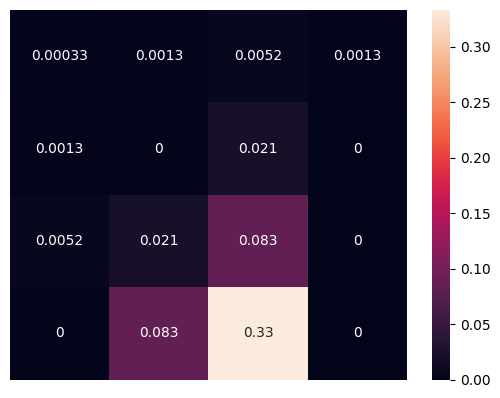

In [90]:
P = get_dynamics(ncol=ncol, nrow=nrow, nS=nS, nA=nA)
policy = np.ones([nS, nA]) / nA # initial strategy
V, policy = optimize_policy(P=P, policy=policy)

seaborn.heatmap(V.reshape(nrow, ncol), annot=True)
plt.axis("off")


In [101]:
policy

array([[0.  , 0.5 , 0.5 , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.5 , 0.5 , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

### 9. Perform 15 traversals over environment with optimal policy `pi_star``  

In [122]:
def get_optimal_action(s_policies):
    """Get randomly action from confined array of optimal policies for the state"""
    return np.random.choice(s_policies)

In [119]:
def get_concrete_episode(env, optimal_policies):
    curr_state, _ = env.reset()
    terminated, truncated = False, False

    # actions of optimal policies map to indices as well
    optimal_actions = [np.argwhere(policy[s] == max_prob).flatten() # map appropriate actions to its probabilities
                       for s, max_prob in  
                       enumerate(np.max(optimal_policies, axis=1)) # get maximum action probabilities for each state
    ]

    # track episode history
    episode = []

    while not(terminated or truncated):
        action = get_optimal_action(optimal_actions[curr_state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((curr_state, action, reward, next_state, terminated, truncated))
        curr_state = next_state

    return episode


In [120]:
policy

array([[0.  , 0.5 , 0.5 , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.5 , 0.5 , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [127]:
exec_time_arr = []
rewards = []
for _ in range(15):
    s_time = time.perf_counter()
    episode = get_concrete_episode(env, policy)
    total_time = time.perf_counter() - s_time
    
    rewards.append(sum([step[2] for step in episode]))
    exec_time_arr.append(total_time)
    

[]

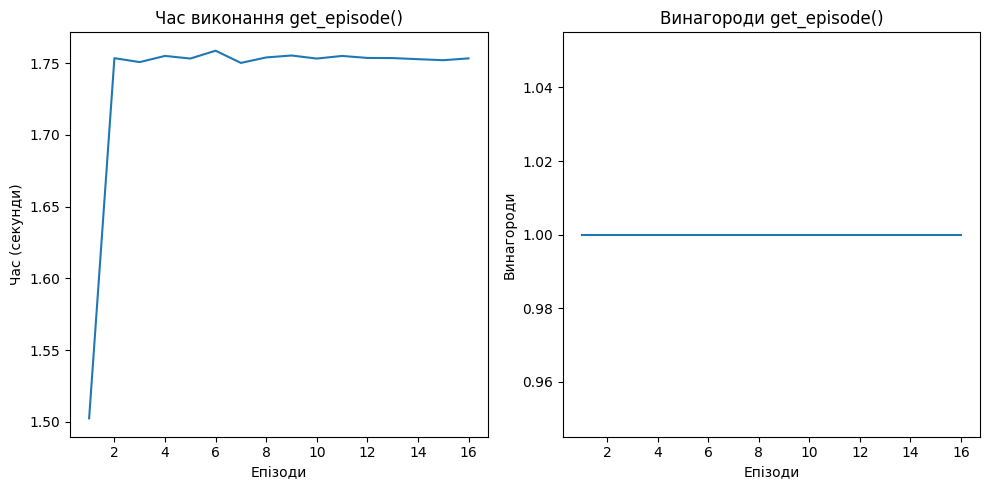

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(1, 17), exec_time_arr)
ax1.set_title("Час виконання get_episode()") # враховуючи час очікування потоку
ax1.set_xlabel("Епізоди")
ax1.set_ylabel("Час (секунди)")

ax2.plot(range(1, 17), rewards)
ax2.set_title("Винагороди get_episode()")
ax2.set_xlabel("Епізоди")
ax2.set_ylabel("Винагороди")

plt.tight_layout()
plt.plot()

### 10. Get Q*(S, a) from V*(S) 

In [129]:
# "left": 0, 
# "down": 1, 
# "right": 2, 
# "up": 3

Q_star = Q_from_v(P, V)
np.round(Q_star, 4)

array([[1.000e-04, 3.000e-04, 3.000e-04, 1.000e-04],
       [1.000e-04, 0.000e+00, 1.300e-03, 3.000e-04],
       [3.000e-04, 5.200e-03, 3.000e-04, 1.300e-03],
       [1.300e-03, 0.000e+00, 3.000e-04, 3.000e-04],
       [3.000e-04, 1.300e-03, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 2.080e-02, 0.000e+00, 1.300e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.300e-03, 0.000e+00, 5.200e-03, 3.000e-04],
       [1.300e-03, 2.080e-02, 2.080e-02, 0.000e+00],
       [5.200e-03, 8.330e-02, 0.000e+00, 5.200e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 2.080e-02, 8.330e-02, 5.200e-03],
       [2.080e-02, 8.330e-02, 3.333e-01, 2.080e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [ ]:
### 11. Implement eps_greedy_policy()

In [148]:
def eps_greedy_policy(q, epsilon):
    r = np.random.rand()
    if r < epsilon:
        # random action
        return np.random.randint(0, len(q))
    else:
        optimal_a = np.max(q)
        return np.random.choince(np.where(q == optimal_a)[0])


In [149]:
env.close()

In [133]:
Q = Q_from_v(P, V)
Q

array([[8.13802083e-05, 3.25520833e-04, 3.25520833e-04, 8.13802083e-05],
       [8.13802083e-05, 0.00000000e+00, 1.30208333e-03, 3.25520833e-04],
       [3.25520833e-04, 5.20833333e-03, 3.25520833e-04, 1.30208333e-03],
       [1.30208333e-03, 0.00000000e+00, 3.25520833e-04, 3.25520833e-04],
       [3.25520833e-04, 1.30208333e-03, 0.00000000e+00, 8.13802083e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.08333333e-02, 0.00000000e+00, 1.30208333e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.30208333e-03, 0.00000000e+00, 5.20833333e-03, 3.25520833e-04],
       [1.30208333e-03, 2.08333333e-02, 2.08333333e-02, 0.00000000e+00],
       [5.20833333e-03, 8.33333333e-02, 0.00000000e+00, 5.20833333e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.08333333e-02, 8.33333333e

In [134]:
np.random.random()

0.9889970491398552

In [136]:
policy

array([[0.  , 0.5 , 0.5 , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.5 , 0.5 , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [135]:
epsilon = 0.1
Q = Q_from_v(P, V)
stochastic_policy = []

for s in range(nS):
    optimal_a = np.argmax(Q[s])
    stochastic_probs = []
    
    for a, a_probab in enumerate(policy[s]):
        if a == optimal_a:
            stochastic_probs.append(1 - epsilon + epsilon/nA)
        else:
            stochastic_probs.append(1/nA)
    stochastic_policy.append(stochastic_probs)
stochastic_policy


[[0.25, 0.925, 0.25, 0.25],
 [0.25, 0.25, 0.925, 0.25],
 [0.25, 0.925, 0.25, 0.25],
 [0.925, 0.25, 0.25, 0.25],
 [0.25, 0.925, 0.25, 0.25],
 [0.925, 0.25, 0.25, 0.25],
 [0.25, 0.925, 0.25, 0.25],
 [0.925, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.925, 0.25],
 [0.25, 0.925, 0.25, 0.25],
 [0.25, 0.925, 0.25, 0.25],
 [0.925, 0.25, 0.25, 0.25],
 [0.925, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.925, 0.25],
 [0.25, 0.25, 0.925, 0.25],
 [0.925, 0.25, 0.25, 0.25]]

In [137]:
def 

np.int64(1)

In [138]:
Q[0]

array([8.13802083e-05, 3.25520833e-04, 3.25520833e-04, 8.13802083e-05])